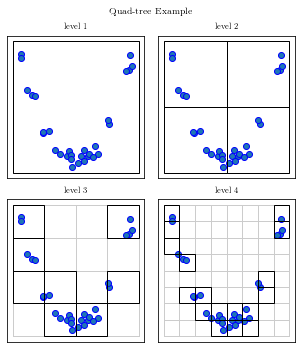

In [1]:

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# We'll create a QuadTree class which will recursively subdivide the
# space into quadrants
class QuadTree:
    """Simple Quad-tree class"""

    # class initialization function
    def __init__(self, data, mins, maxs, depth=3):
        self.data = np.asarray(data)

        # data should be two-dimensional
        assert self.data.shape[1] == 2

        if mins is None:
            mins = data.min(0)
        if maxs is None:
            maxs = data.max(0)

        self.mins = np.asarray(mins)
        self.maxs = np.asarray(maxs)
        self.sizes = self.maxs - self.mins

        self.children = []

        mids = 0.5 * (self.mins + self.maxs)
        xmin, ymin = self.mins
        xmax, ymax = self.maxs
        xmid, ymid = mids

        if depth > 0:
            # split the data into four quadrants
            data_q1 = data[(data[:, 0] < mids[0])
                           & (data[:, 1] < mids[1])]
            data_q2 = data[(data[:, 0] < mids[0])
                           & (data[:, 1] >= mids[1])]
            data_q3 = data[(data[:, 0] >= mids[0])
                           & (data[:, 1] < mids[1])]
            data_q4 = data[(data[:, 0] >= mids[0])
                           & (data[:, 1] >= mids[1])]

            # recursively build a quad tree on each quadrant which has data
            if data_q1.shape[0] > 0:
                self.children.append(QuadTree(data_q1,
                                              [xmin, ymin], [xmid, ymid],
                                              depth - 1))
            if data_q2.shape[0] > 0:
                self.children.append(QuadTree(data_q2,
                                              [xmin, ymid], [xmid, ymax],
                                              depth - 1))
            if data_q3.shape[0] > 0:
                self.children.append(QuadTree(data_q3,
                                              [xmid, ymin], [xmax, ymid],
                                              depth - 1))
            if data_q4.shape[0] > 0:
                self.children.append(QuadTree(data_q4,
                                              [xmid, ymid], [xmax, ymax],
                                              depth - 1))

    def draw_rectangle(self, ax, depth):
        """Recursively plot a visualization of the quad tree region"""
        if depth is None or depth == 0:
            rect = plt.Rectangle(self.mins, *self.sizes, zorder=2,
                                 ec='#000000', fc='none')
            ax.add_patch(rect)
        if depth is None or depth > 0:
            for child in self.children:
                child.draw_rectangle(ax, depth - 1)


def draw_grid(ax, xlim, ylim, Nx, Ny, **kwargs):
    """ draw a background grid for the quad tree"""
    for x in np.linspace(xlim[0], xlim[1], Nx):
        ax.plot([x, x], ylim, **kwargs)
    for y in np.linspace(ylim[0], ylim[1], Ny):
        ax.plot(xlim, [y, y], **kwargs)


#------------------------------------------------------------
# Create a set of structured random points in two dimensions
np.random.seed(0)

X = np.random.random((30, 2)) * 2 - 1
X[:, 1] *= 0.1
X[:, 1] += X[:, 0] ** 2

#------------------------------------------------------------
# Use our Quad Tree class to recursively divide the space
mins = (-1.1, -0.1)
maxs = (1.1, 1.1)
QT = QuadTree(X, mins, maxs, depth=3)

#------------------------------------------------------------
# Plot four different levels of the quad tree
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(wspace=0.1, hspace=0.15,
                    left=0.1, right=0.9,
                    bottom=0.05, top=0.9)

for level in range(1, 5):
    ax = fig.add_subplot(2, 2, level, xticks=[], yticks=[])
    ax.scatter(X[:, 0], X[:, 1])
    QT.draw_rectangle(ax, depth=level - 1)

    Nlines = 1 + 2 ** (level - 1)
    draw_grid(ax, (mins[0], maxs[0]), (mins[1], maxs[1]),
              Nlines, Nlines, linewidth=1,
              color='#CCCCCC', zorder=0)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-0.15, 1.15)
    ax.set_title('level %i' % level)

# suptitle() adds a title to the entire figure
fig.suptitle('Quad-tree Example')
plt.show()
